<a href="https://colab.research.google.com/github/kgrisk/Kaggle_Notebooks/blob/master/Pixel_Similarity_with_Kannada_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install fastai2
#!pip install panda



#Pixel Similarity with Kannada-MNIST


Pixel similarity is a basic and easy to understand approach for image recognition. It might not give you as good results as a neural network, but it could be used as a starting model for your problem. To implement Pixel similarity, all you need to do is:
1. Find some images representing the same thing.
2. Calculate the means of unique values.
3. Use it for predictions.


This blog will show you step by step implementation of pixel similarity using something as Kannada-MNIST dataset.

First thing you need to do is import the libraries.

In [0]:
import numpy as np
from torch import tensor,Size
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

Then you need to go to kaggle website,  download the Kannada-MNIST dataset and unzip it. In Kannada-MNIST case we have 4 files ziped in it.
For this implementation I am going to be using only 'train.csv'.

In [4]:
!chmod 777 Kannada-MNIST.zip
!unzip Kannada-MNIST.zip

Archive:  Kannada-MNIST.zip
replace Dig-MNIST.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


The easy way of how you can read the 'train.csv' file is to use pandas function 'read_csv()'. It will read it into pandas DataFrame.
By calling 'head()' on it, we can display the first five rows of its content.
The first column of it is 'label'. It defines what category the row belongs to. 
Each of the other columns represents the pixels from 0 to 784, which is a flattened 28,28 shaped single-channel image.

In [5]:
df = pd.read_csv("train.csv") 
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


By using pandas 'iloc', we can index our DataFrame based on integer-location, just like any multidimensional array. By converting it into numpy array and reshaping to the 28,28 size image, we can display it using PIL.Image 'fromarray()' function.

In [6]:
example = df.iloc[12, 1:].to_numpy().astype(np.uint8).reshape(28, 28)
Image.fromarray(example)

We can also inspect only a specific part of it to see how the image looks in the simple array format. By looking inside of the example, we can see that the image is only but a pixel matrix with values ranging from 0 to 255.

In [7]:
example[4:15,10:22]

array([[  0,  14, 184, 198, 234, 226, 127,   0,   0,   0,   0,   0],
       [  0,  18, 237, 130,  96,  96, 118, 125,   0,   0,   0,   0],
       [  0,  18, 237,  54,   0,  61, 169, 200,   0,   0,   0,   0],
       [  0,  18, 237,  55,   0, 127, 255, 200,   0,   0,   0,   0],
       [  0,  18, 237,  55,   0, 127, 255, 200,   0,   0,   0,   0],
       [  0,  18, 237,  60,   6, 127, 251, 200,   0,   0,   0,   0],
       [  0,  18, 237, 230, 223, 127, 111, 200,   0,   0,   0,   0],
       [  0,   5,  65, 215, 136,  35,  25,  55,   0,   0,   0,   0],
       [  0,   0,   0,  85,  39,   0,   0,  31, 147,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  54, 255,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  55, 255,   0,   0,   0]],
      dtype=uint8)

The same array can be very easily converted into the tensor and iterated in the same way.

In [8]:
img_t = tensor(example)
img_t[4:15,10:22]

tensor([[  0,  14, 184, 198, 234, 226, 127,   0,   0,   0,   0,   0],
        [  0,  18, 237, 130,  96,  96, 118, 125,   0,   0,   0,   0],
        [  0,  18, 237,  54,   0,  61, 169, 200,   0,   0,   0,   0],
        [  0,  18, 237,  55,   0, 127, 255, 200,   0,   0,   0,   0],
        [  0,  18, 237,  55,   0, 127, 255, 200,   0,   0,   0,   0],
        [  0,  18, 237,  60,   6, 127, 251, 200,   0,   0,   0,   0],
        [  0,  18, 237, 230, 223, 127, 111, 200,   0,   0,   0,   0],
        [  0,   5,  65, 215, 136,  35,  25,  55,   0,   0,   0,   0],
        [  0,   0,   0,  85,  39,   0,   0,  31, 147,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  54, 255,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  55, 255,   0,   0,   0]],
       dtype=torch.uint8)

The conversion back to DataFrame is also very straightforward.
Dataframe also has a way to visualize its information in multiple ways, for example displaying the image as matrix and painting its values depending on their magnitude.

In [9]:
df_example = pd.DataFrame(example[4:15,4:22])
df_example.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,14,184,198,234,226,127,0,0,0,0,0
1,0,0,0,0,0,0,0,18,237,130,96,96,118,125,0,0,0,0
2,0,0,0,0,0,0,0,18,237,54,0,61,169,200,0,0,0,0
3,0,0,0,0,0,0,0,18,237,55,0,127,255,200,0,0,0,0
4,0,0,0,0,0,0,0,18,237,55,0,127,255,200,0,0,0,0
5,0,0,0,0,0,0,0,18,237,60,6,127,251,200,0,0,0,0
6,0,0,0,0,0,0,0,18,237,230,223,127,111,200,0,0,0,0
7,0,0,0,0,0,0,0,5,65,215,136,35,25,55,0,0,0,0
8,0,0,0,0,0,0,0,0,0,85,39,0,0,31,147,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,54,255,0,0,0


### Means Calculation

Going back to creating our model, it is always a good idea to split your data into training and test sets. One will be used to prepare the solution, and another will be used to check how good it is. In my case, I have done it by using numpy 'split()' function. It supports many formats and can take pandas DataFrame and split it directly with you only needing to specify how you want to split it. I have decided to do a one split of 20 %, which will be my test set. All other data will go into another set, which will be used for calculating our mean values.

In [10]:
 test_df,train_df= np.split(df,[int(.2*len(df)), ])
len(test_df), len(train_df)

(12000, 48000)

By using matplotlib library, we can plot and inspect our images. 'subplots' function can be used to define the area where we can plot multiple images and show them at the same time.

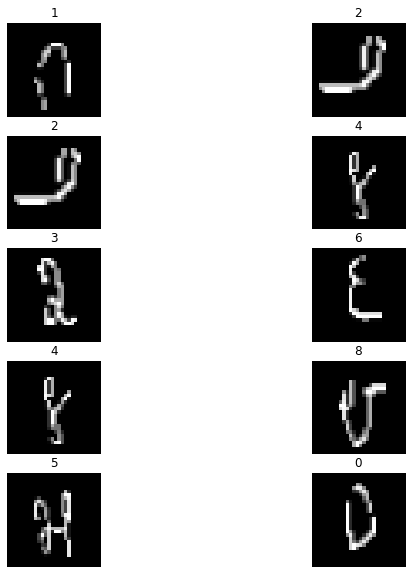

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10))
for i in range(2):
    for j in range(5):

        ax[j][i].set_title(train_df.iloc[(j+1)*(i+1),0])
        ax[j][i].axis('off')
        ax[j][i].imshow(train_df.iloc[(j+1)*(i+1),1:].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

By using 'groupby()' function, we can group our data according to a specific column's unique values. In our case, it is 'label'.Afterward, by calling 'mean()' on it, we can calculate the mean between all the data examples grouped under the same unique value.  

In [0]:
train_df_mean = train_df.groupby('label').mean()


In the end, it gives us a new DataFrame containing the means of all different unique numbers in this Dataset(0 to 9).

In [13]:
train_df_mean

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.073958,0.084375,0.151458,0.143333,0.054583,0.076042,0.029583,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.023542,0.041250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.047292,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.741458,1.984792,3.218542,4.959792,3.089375,1.791250,0.542083,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159375,0.108542,0.043750,0.351667,0.277292,0.121042,0.002708,0.000000,0.053125,0.049375,0.121667,0.107708,0.154167,0.090417,0.173542,0.053125,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025208,0.051667,0.022500,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.041042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.043125,0.016458,0.000000,0.000000,0.000000,0.000000,0.003333,0.049792,0.010000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.05125,0.000000,0.188542,0.102292,0.163125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.422292,0.113125,0.065417,0.006667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021250,0.007083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.587292,1.286667,0.919375,0.652708,0.148542,0.080833,0.017708,0.053125,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

By displaying it visually, we can see how the pixels, which often repeats in the images under the same 'label' is painted in bright white, indicating high numeric value. Likewise, the pixels who still appear in some examples but not often are not painted that brightly showing lower value. And the pixels which never appeared are painted black(indicating zero).

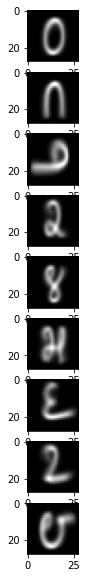

In [14]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(10,10))

for j in range(9):
    ax[j].imshow(train_df_mean.iloc[j,:].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

### Calculating Distance between means and Test set
We have found the means for numbers of all training examples now let's see how we can test it.  

For the test set, we don't need to have 'label' column in our DataFrame.  For convenience, we are going to take it out from DataFrame and save it individually as a tensor. 

In [0]:
test_targets = tensor(test_df['label'])
test_df = test_df.drop('label', axis=1)

We need to normalize our data. We are going to do it by dividing everything from the biggest value, which will give us everything in a range between 0 and 1.

In [0]:
test_df_tensor = tensor(test_df.values)/255.
train_df_mean_tensor = tensor(train_df_mean.values)/255.

Lets take one example for a test run.

In [17]:
test_example = test_df_tensor[3,]
test_targets[3],

(tensor(3),)

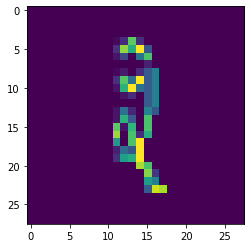

In [47]:
plt.imshow(test_example.reshape(28, 28))

Now we are going to calculate our pixels distance between mean and test example. The most direct approach would be to subtract the pixels of one image from another and then calculate the mean between all pixel distances. This approach has one problem. Some of our pixel differences will have negative values, and that will make our mean inaccurate. We are going to solve this two ways and will compare it:

1.   After we calculate our distances between pixels of different images, we are going to convert it to their absolute values. Then all of our values will be positive, and we can calculate the mean of all pixel distances.
2.   After we calculate our distances between pixels of different images,  we are going to power them by 2(this will let us get rid of all negative values) calculate mean as before, and square it.

These two solutions are also called l1 and l2 regularization techniques and are used all around machine learning.



In [18]:
#l1
dist_3_abs = (test_example - train_df_mean_tensor[3]).abs().mean(-1)
#l2
dist_3_sqr = ((test_example - train_df_mean_tensor[3])**2).mean(-1).sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.0689, dtype=torch.float64), tensor(0.1543, dtype=torch.float64))

Because of python broadcasting capabilities, we can also calculate the distance between all unique value means and test example at the same time. Test example image tensor is of shape ([784]). The means tensor is of shape ([10,784]). As we can see, the second dimension of means tensor is of the same size as the test image. In this kind of case, python automatically applies extra dimension to the tensor with a missing dimension (in this case, making it ([1,784]))and broadcast it across all elements of the bigger tensor doing the required operation.

In [19]:
print(test_example.shape)
print(train_df_mean_tensor.shape)
#l1
dist_3_abs = (test_example - train_df_mean_tensor).abs().mean(-1)
#l2
dist_3_sqr = ((test_example - train_df_mean_tensor)**2).mean(-1).sqrt()
dist_3_abs,dist_3_sqr

torch.Size([784])
torch.Size([10, 784])


(tensor([0.1031, 0.0921, 0.1032, 0.0689, 0.0696, 0.1024, 0.0902, 0.0762, 0.1188,
         0.0866], dtype=torch.float64),
 tensor([0.2152, 0.1992, 0.2002, 0.1543, 0.1583, 0.1908, 0.1903, 0.1643, 0.2199,
         0.1829], dtype=torch.float64))

As we can see with the current example, the smallest difference belongs to the mean of number 3, which is a correct prediction.

In [20]:
print(dist_3_abs.argmin(),dist_3_abs.min())
print(dist_3_sqr.argmin(),dist_3_sqr.min())

tensor(3) tensor(0.0689, dtype=torch.float64)
tensor(3) tensor(0.1543, dtype=torch.float64)


Lets put our distance calculation into the functions as it will be more convenient.

In [0]:
def mnist_distance_abs(a,b): return (a-b).abs().mean((-1))
def mnist_distance_sqrt(a,b): return ((a-b)**2).mean(-1).sqrt()

We calculated prediction for one example now let's try to do it for all test set and see that we get.
To calculate a prediction for all test set at the same time, we will need to do something extra. If we inspect our test set shape, we will see that we cannot use broadcasting. Both test and mean tensors have 2 dimensions, but one of them at the first dimension has 12000 values and another 10. Before, we could apply broadcasting across all elements only because one of the tensors had a dimension of 1, and python could create an additional dimension for it at the start and apply it to all elements of the second tensor with 2 dimensions.


In [22]:
print(test_df_tensor.shape)
print(train_df_mean_tensor.shape)

torch.Size([12000, 784])
torch.Size([10, 784])


One way to overcome it would be to loop through each element of one tensor and broadcast its information to another. That would work, but that would be too inefficient as python loops are way more expensive compared to broadcasting. That we can do in this situation is to use 'unsqueeze()' function. That 'unsqueeze' basically does it add an extra dimension to our tensor at the specified index.

In [23]:
print(test_df_tensor.shape)
print(test_df_tensor.unsqueeze(0).shape)
print(test_df_tensor.unsqueeze(1).shape)
print(test_df_tensor.unsqueeze(2).shape)
print(train_df_mean_tensor.shape)
print(train_df_mean_tensor.unsqueeze(0).shape)
print(train_df_mean_tensor.unsqueeze(1).shape)
print(train_df_mean_tensor.unsqueeze(2).shape)

torch.Size([12000, 784])
torch.Size([1, 12000, 784])
torch.Size([12000, 1, 784])
torch.Size([12000, 784, 1])
torch.Size([10, 784])
torch.Size([1, 10, 784])
torch.Size([10, 1, 784])
torch.Size([10, 784, 1])


In our case, we are going to add an extra dimension in the middle for our test set tensor. So instead of shape ([12000,784]) it will now be ([12000,1,784]). So now, it will have one dimension difference with our means tensor ([10,78]).

In [24]:
print(test_df_tensor.unsqueeze(1).shape)
print(train_df_mean_tensor.shape)

torch.Size([12000, 1, 784])
torch.Size([10, 784])


So now we are going to do the same thing as before, but instead of the calculating distance between 1 example and means, we are going to calculate the distance between means and all of our test set.
As I mentioned before now, we are going to have 2 tensors. One of shape ([12000,1,784]). Second of shape ([10,784]). Because the second tensor has one dimension less, before doing subtraction operation python will add an extra dimension to this tensor making it ([1,10,784]). This dimension will be used to apply this tensor across all 12000 examples from the test tensor(first dimension).
While applying it 12000 times, each time on applying,  the ([1,784]) tensors part from the test set will be applied to the ([10,784]) means tensor just how it was done with test example image tensor before.

In [0]:
def mnist_distance_abs(a,b): return (a-b).abs().mean(-1)
val_dist_abs = mnist_distance_abs(test_df_tensor.unsqueeze(1), train_df_mean_tensor)

In [0]:
def mnist_distance_sqrt(a,b): return ((a-b)**2).mean(-1).sqrt()
val_dist_sqrt = mnist_distance_sqrt(test_df_tensor.unsqueeze(1), train_df_mean_tensor)

So, in the end, we are left with a 2-dimensional tensor containing the distance to each example from the test set to the respective mean of number.

In [27]:
print(val_dist_abs.shape)
val_dist_abs[:5]

torch.Size([12000, 10])


tensor([[0.0743, 0.0786, 0.1267, 0.1039, 0.1003, 0.1148, 0.1221, 0.1151, 0.0985,
         0.0947],
        [0.0966, 0.0797, 0.1264, 0.1057, 0.1059, 0.1151, 0.1134, 0.1136, 0.1199,
         0.1037],
        [0.1390, 0.1282, 0.0996, 0.1127, 0.1278, 0.1341, 0.1208, 0.1183, 0.1452,
         0.1352],
        [0.1031, 0.0921, 0.1032, 0.0689, 0.0696, 0.1024, 0.0902, 0.0762, 0.1188,
         0.0866],
        [0.0995, 0.0942, 0.1116, 0.0799, 0.0662, 0.0997, 0.1021, 0.0913, 0.1137,
         0.0895]], dtype=torch.float64)

Let's get the indexes of distances containing the lowest value. Again we are going to use 'argmin()' function, but this time we are also going to specify dimension. Last time the tensor contained only one dimension, so we did not need to do this, but this time we have to. By specifying -1 we get the last dimension, meaning we are getting the smallest value from the last dimension.

In [0]:
prediction_abs = val_dist_abs.argmin(-1)
prediction_sqrt = val_dist_sqrt.argmin(-1)

Now we are going to compare our predictions to the actual values(label tensor that we saved separately) to record how many of them were categorized correctly. 

In [0]:
result_abs = prediction_abs == test_targets
result_sqrt = prediction_sqrt == test_targets


This is a tensor with boolean values representing whatever the example was categorized correctly.

In [30]:
result_abs, result_sqrt

(tensor([ True,  True,  True,  ...,  True, False, False]),
 tensor([ True,  True,  True,  ...,  True,  True, False]))

We can convert them to float and calculate their mean that way, getting our predictions.

In [31]:
result_abs.float() .mean(), result_sqrt.float() .mean()

(tensor(0.7606), tensor(0.8470))